In [1]:
from Binaries import *
Th1 = HardwareClassifier(["th1"])
ToT = HardwareClassifier(["tot"])
ToTd = HardwareClassifier(["totd"])

In [2]:
vem_compatibility = np.array([163.235 for _ in range(3)])
th1_fuckups = []
tot_fuckups = []
totd_fuckups = []

EventsLTP = EventGenerator("/cr/tempdata01/filip/QGSJET-II/LTP/extracted/", apply_downsampling = True, q_peak = vem_compatibility, split = 1, real_background = False, sigma = 0)

for i, batch in enumerate(EventsLTP):
    print(f"{EventsLTP.files[i]}, {i}/{len(EventsLTP)}                       ", end = "\r")

    for trace in batch:

        is_th1, is_tot, is_totd = trace.n_muons, trace.n_electrons, trace.n_photons

        if is_th1: 
            if not Th1(trace):
                th1_fuckups.append([trace.StationID, trace.EventFile])

        if is_tot: 
            if not ToT(trace):
                tot_fuckups.append([trace.StationID, trace.EventFile])

        if is_totd: 
            if not ToTd(trace):
                totd_fuckups.append([trace.StationID, trace.EventFile])

In [3]:
print(len(th1_fuckups))
print(len(tot_fuckups))
print(len(totd_fuckups))

175
1804
18798


# Issue with random phase?

In [6]:
th1_total_fuckups = []
tot_total_fuckups = []
totd_total_fuckups = []

iterator = [[th1_fuckups, th1_total_fuckups], [tot_fuckups, tot_total_fuckups], [totd_fuckups, totd_total_fuckups]]

for j, (trigger_fuckups, total_fuckups) in enumerate(iterator):
    for ID, file in trigger_fuckups:

        signal_data = SignalBatch(file)

        for station in signal_data:
            if station[0][0] != ID: continue

            baseline = EventsLTP.build_baseline()

            for i in range(3):
                EventsLTP.trace_options["random_phase"] = i
                VEMTrace = Trace(baseline, station, EventsLTP.trace_options, file)

                # plt.figure()
                # plt.ylim(-0.5,1.9)
                # VEMTrace.__plot__()
                # plt.xlim(220, 300)

                # plt.axhline(1.75, c = "gray", ls = "--")

                if j == 0:
                    if Th1(VEMTrace):
                        break
                elif j==1:
                    if ToT(VEMTrace):
                        break
                elif j==2:
                    if ToTd(VEMTrace):
                        break

            else:
                total_fuckups.append([ID, file])

    print(f"{j = }: {len(total_fuckups)} remaining, {len(trigger_fuckups) - len(total_fuckups)} fixed")

j = 0: 24 remaining, 151 fixed
j = 1: 1427 remaining, 377 fixed
j = 2: 16549 remaining, 2249 fixed


In [11]:
np.savetxt("th1_fuckups/th1_fuckups.txt", th1_total_fuckups, fmt = "%s")
np.savetxt("tot_fuckups/tot_fuckups.txt", tot_total_fuckups, fmt = "%s")
np.savetxt("totd_fuckups/totd_fuckups.txt", totd_total_fuckups, fmt = "%s")

In [ ]:
for i, (ID, file) in enumerate(total_fuckups):

   print(ID, file)

In [ ]:
for id, file in total_fuckups:

    print(file.replace("extracted", "19_19.5")[:-4]+".root")

-0.5573034762453496
-0.5570010461488479
-0.5569421557347443


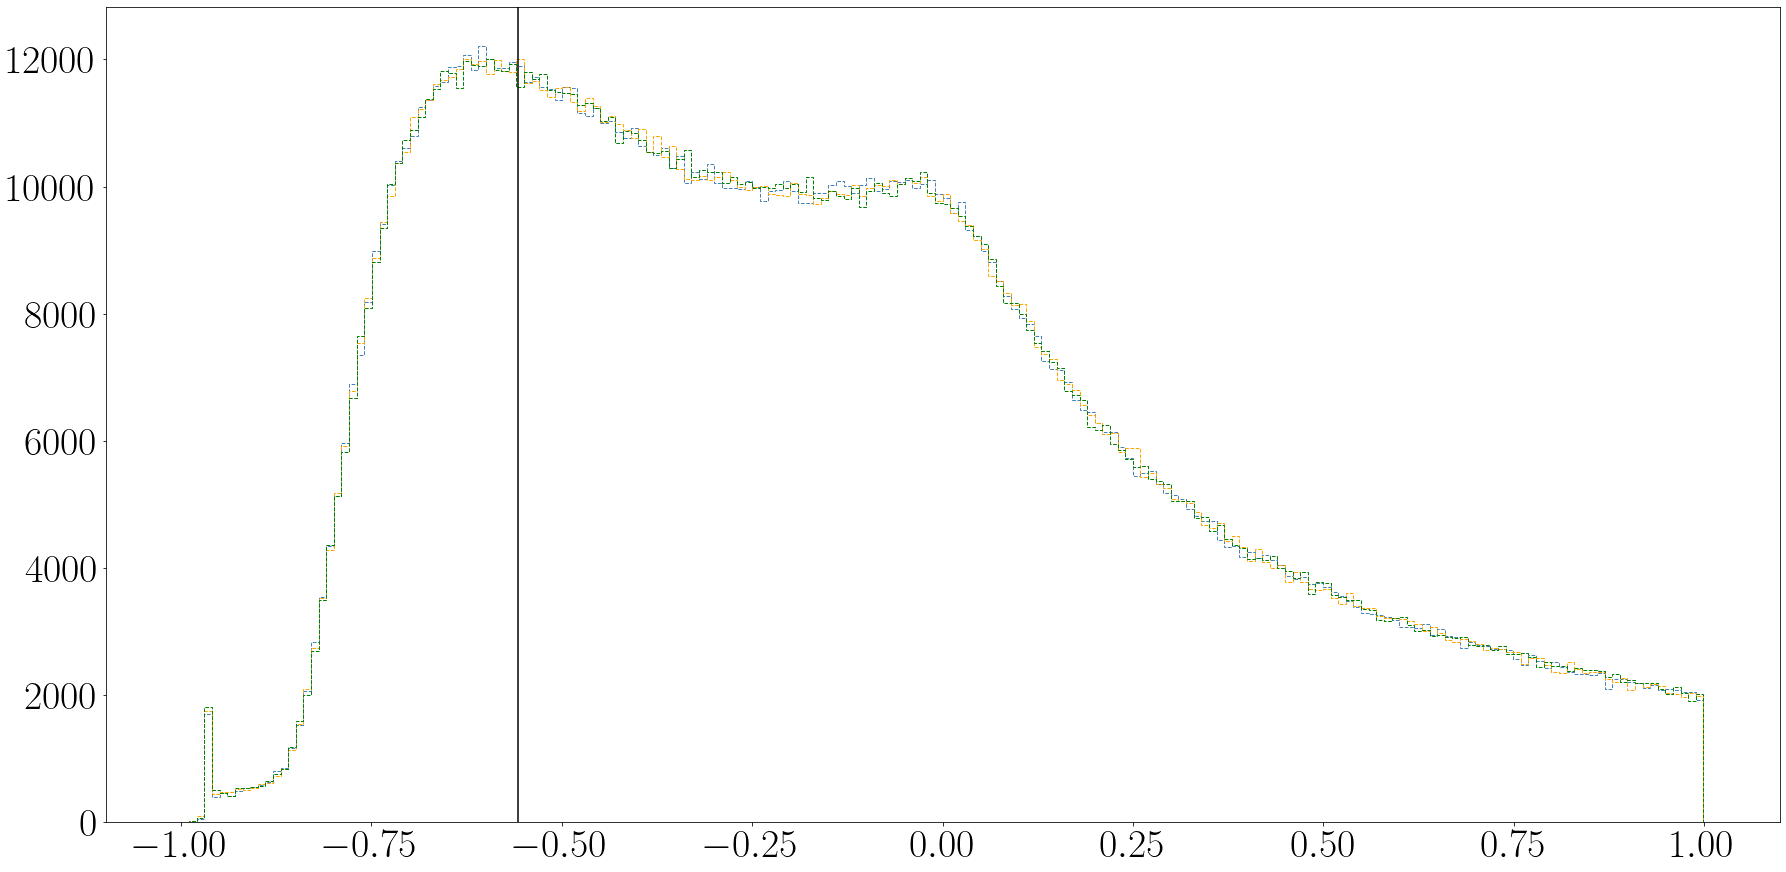

In [11]:
from Binaries import *

th1_total_fuckups = np.loadtxt("./th1_fuckups/th1_fuckups.txt", dtype = str)
tot_total_fuckups = np.loadtxt("./tot_fuckups/tot_fuckups.txt", dtype = str)
q_peak_compatibility =np.array([GLOBAL.q_peak_compatibility for _ in range(3)])
source = "/cr/users/filip/Trigger/OfflineComparison/"

all1, all2, all3 = [], [], []

for i, total_fuckups in enumerate([th1_total_fuckups, tot_total_fuckups]):

    path = source 
    path += "th1_fuckups/" if i == 0 else "tot_fuckups/"

    VEM = EventGenerator(path + "VEM/", split = 1, real_background = False, seed = 42, is_vem = True, random_phase = 0, apply_downsampling = True)
    ADC = EventGenerator(path + "ADC/", split = 1, real_background = False, seed = 42, is_vem = False, random_phase = 0, apply_downsampling = True)

    for i, (ID, file) in enumerate(total_fuckups):

        try:
            tracesVEM = VEM.__getitem__(VEM.find(file))
            tracesADC = ADC.__getitem__(ADC.find(file))

            for adc, vem in zip(tracesVEM, tracesADC):

                for j in range(len(vem.pmt_1)):
                    all1.append(vem.pmt_1[j]/adc.pmt_1[j] - 1)
                    all2.append(vem.pmt_2[j]/adc.pmt_2[j] - 1)
                    all3.append(vem.pmt_3[j]/adc.pmt_3[j] - 1)
                
        except ValueError: continue

kwargs = {"histtype" : "step", "range" : [-0.999, 0.999], "bins" : 200}

all1 = np.clip(all1, -1, 1)
all2 = np.clip(all2, -1, 1)
all3 = np.clip(all3, -1, 1)

n1, _, _ = plt.hist(all1, color = "steelblue", ls = "--", **kwargs)
n2, _, _ = plt.hist(all2, color = "orange", ls = "--", **kwargs)
n3, _, _ = plt.hist(all3, color = "green", ls = "--", **kwargs)

plt.axvline(np.mean(all1), c = "k")
# plt.axvline(np.mean(all2), c = "k")
# plt.axvline(np.mean(all3), c = "k")

print(np.mean(all1))
print(np.mean(all2))
print(np.mean(all3))

# plt.xlabel("recStation.GetVEMTrace / $\Sigma\limits_{\mathrm{component}}$ recStation.GetPMTTrace(component) - 1")

# plt.plot([],[], ls = "solid", label = "Th1 fails $\cdot$ 10", c = "k")
# plt.plot([],[], ls = "--", label = "All traces", c = "k")

# plt.legend()

-0.1348816016083482
-0.1329721214020081
-0.131949990090505


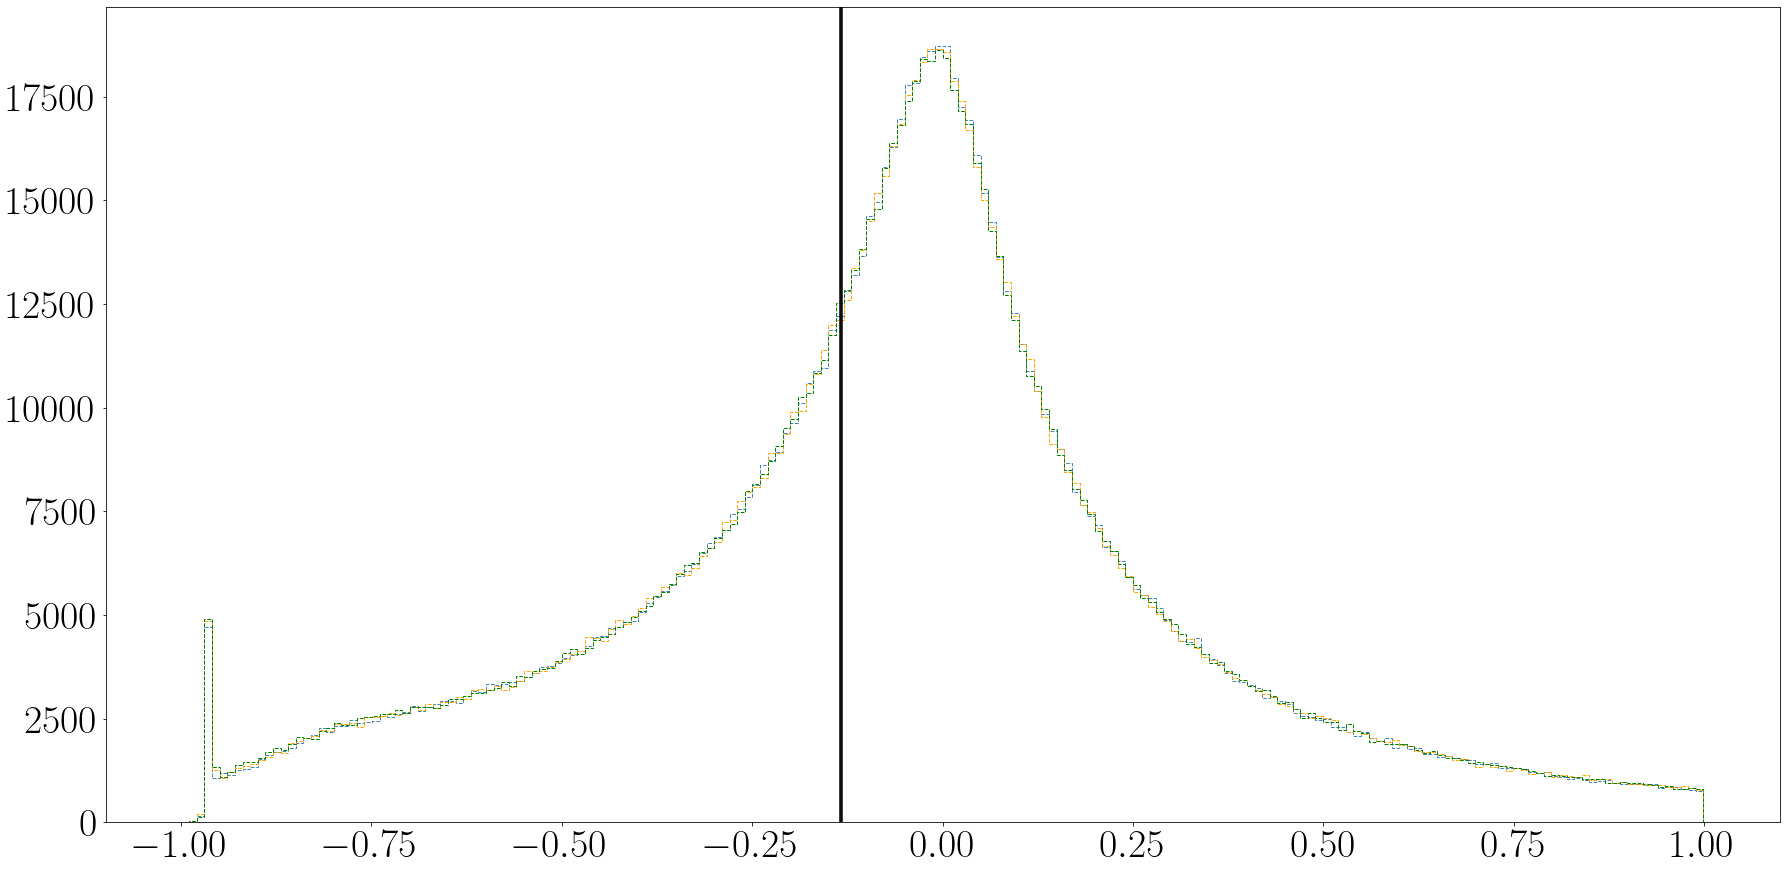

In [16]:
kwargs = {"histtype" : "step", "range" : [-0.999, 0.999], "bins" : 200}

all1 = np.clip(all1, -1, 1)
all2 = np.clip(all2, -1, 1)
all3 = np.clip(all3, -1, 1)

n1, _, _ = plt.hist(all1, color = "steelblue", ls = "--", **kwargs)
n2, _, _ = plt.hist(all2, color = "orange", ls = "--", **kwargs)
n3, _, _ = plt.hist(all3, color = "green", ls = "--", **kwargs)

plt.axvline(np.mean(all1), c = "k")
plt.axvline(np.mean(all2), c = "k")
plt.axvline(np.mean(all3), c = "k")

print(np.mean(all1))
print(np.mean(all2))
print(np.mean(all3))

-0.1223606661693135
-0.13359309028722152
-0.14131568180055895


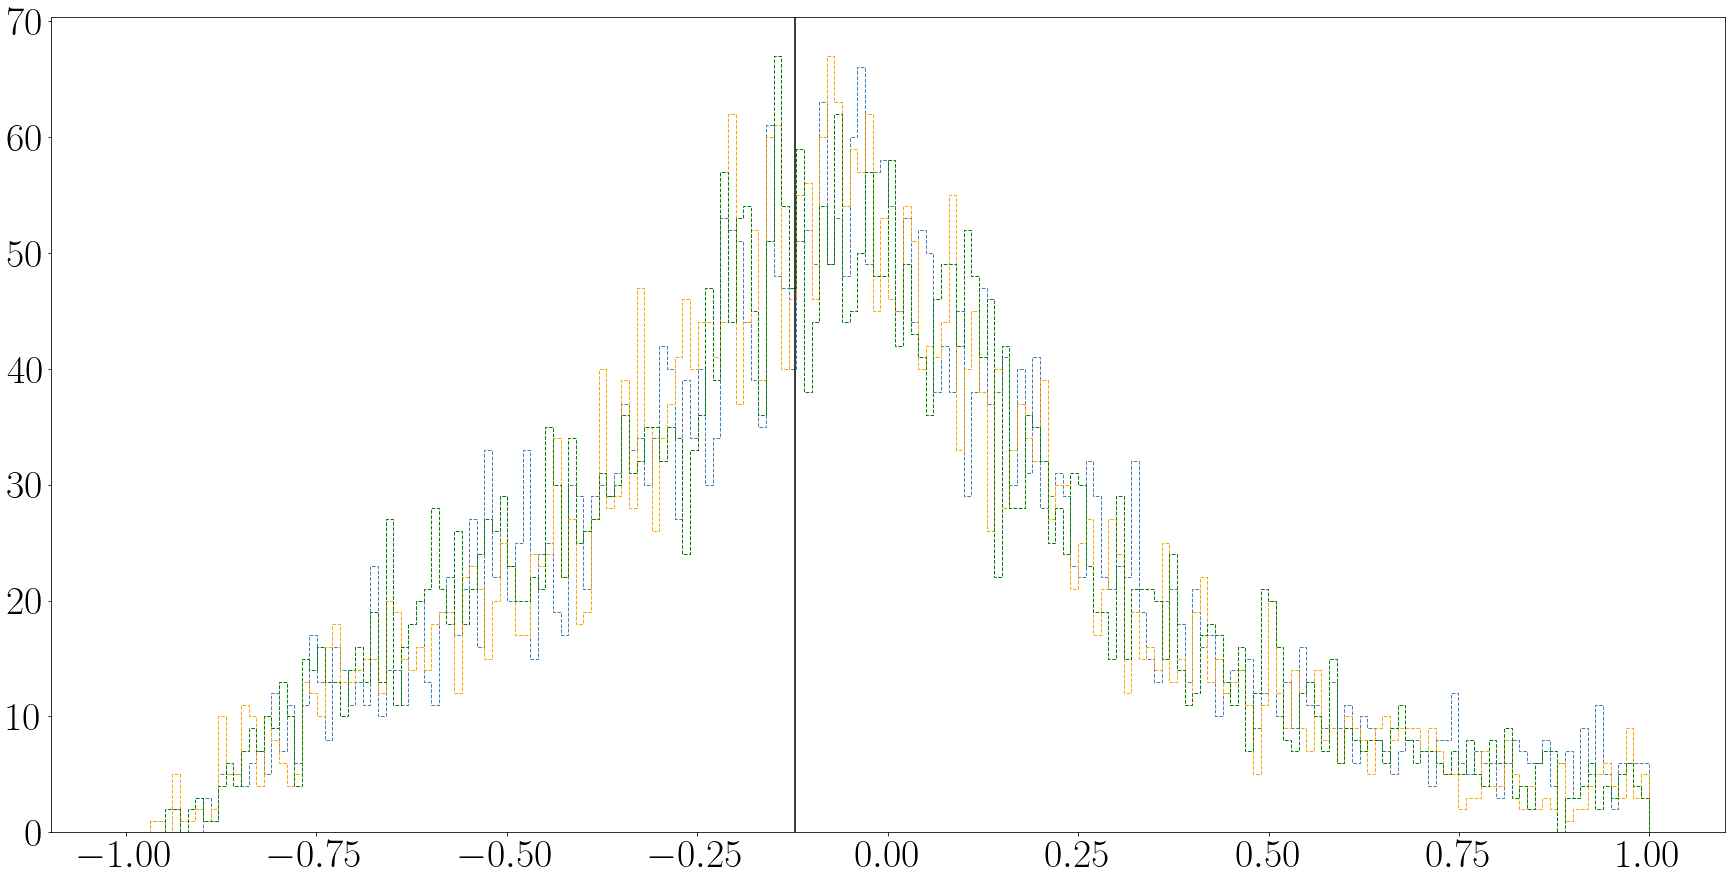

In [3]:
kwargs = {"histtype" : "step", "range" : [-0.999, 0.999], "bins" : 200}

all1 = np.clip(all1, -1, 1)
all2 = np.clip(all2, -1, 1)
all3 = np.clip(all3, -1, 1)

n1, _, _ = plt.hist(all1, color = "steelblue", ls = "--", **kwargs)
n2, _, _ = plt.hist(all2, color = "orange", ls = "--", **kwargs)
n3, _, _ = plt.hist(all3, color = "green", ls = "--", **kwargs)

plt.axvline(np.mean(all1), c = "k")
# plt.axvline(np.mean(all2), c = "k")
# plt.axvline(np.mean(all3), c = "k")

print(np.mean(all1))
print(np.mean(all2))
print(np.mean(all3))